In [12]:
%matplotlib inline
import json
import urllib2
import os
from tables import open_file
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from alleninf.api import get_probes_from_genes
from alleninf.data import get_values_at_locations
from alleninf.api import get_mni_coordinates_from_wells#
from alleninf.analysis import fixed_effects, approximate_random_effects, bayesian_random_effects
import statsmodels.formula.api as smf
import math 
sns.set_style('white')
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999

api_url = "http://api.brain-map.org/api/v2/data/query.json"
ahba_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/AUG5/AHBA2'
save_fig_dir        = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v2'


In [13]:
##################################################################################################
# Iron
##################################################################################################

down_regulated_genes = { # Clardy et al. (2006). Acute and chronic effects of developmental iron deficiency 
                         # on mRNA expression patterns in the brain. Journal of Neural Transmission, 71, 173–96. 
                         # http://www.ncbi.nlm.nih.gov/pubmed/17447428
                    'THRSP'      :  'thyroid hormone responsive protein',
                    #''          :  'Rattus norvegicus Nclone10 mRNA',
                    'TF'         :  'transferrin',
                    'MAL'        :  'mal, T-cell differentiation protein',
                    'KLK6'       :  'kallikrein-related peptidase 6', 
                    'HOMER1'     :  'homer homolog 1 (Drosophila), neuronal immediate early gene',
                    'MOBP'       :  'myelin-associated oligodendrocytic basic protein',
                    'APOD'       :  'apolipoprotein D',
                    #''          :  'Rat troponin-c mRNA'
                    'MOG'        :  'myelin oligodendrocyte glycoprotein',
                    'CRYAB'      :  'crystallin, alpha B',
                    #'Af6'       :  'afadin',
                    #''           :  'Rattus norvegicus retroviral-like ovarian specific transcript 30-1 mRNA',
                    'APOC1'      :  'apolipoprotein C-I',
                    'CA2'        :  'carbonic anhydrase II',
                    'RASGRP1'    :  'RAS guanyl releasing protein 1',
                    'STMN4'      :  'stathmin-like 4',
                    #'Rnf28'      :  'ring finger protein 28',
                    'LYZ'        :  'lysozyme', 
                    #'LOC309574' :  'olfactory receptor',
                    'GSTM1'      :  'glutathione S-transferase mu 1', 
                    'CTSS'       :  'cathepsin S', 
                    'DCK'        :  'deoxycytidine kinase',
                    #''           :  'Rattus norvegicus similar to S-100 protein, alpha chain (LOC295214), mRNA',
                    #''           :  'Rat PMSG-induced ovarian mRNA, 3’sequence, N1'
                       }

iron_homeostasis_gene_set = { # http://amp.pharm.mssm.edu/Harmonizome/gene_set/Iron+Homeostasis(Mus+musculus)/Wikipathways+Pathways
                    'FTH1': 'ferritin heavy polypeptide 1',
                    'FTL' : 'ferritin light polypeptide',
                    'HFE' :'hemochromatosis',
                    'HFE2' :'hemochromatosis type 2 (juvenile)',
                    'IL1A' :'interleukin 1, alpha',
                    'IL6' :'interleukin 6',
                    'IL6R' :'interleukin 6 receptor',
                    'IREB2':'iron-responsive element binding protein 2',
                    'SLC40A1':'solute carrier family 40 (iron-regulated transporter), member 1',
                    'TF':'transferrin',
                    'TFR2':'transferrin receptor 2',
                    'TNF' : 'tumor necrosis factor',
}

##################################################################################################
#Dopamine
##################################################################################################

DA_metabolism_gene_set = { # http://amp.pharm.mssm.edu/Harmonizome/gene_set/Dopamine+metabolism(Homo+sapiens)/Wikipathways+Pathways
                    'COMT': 'catechol-O-methyltransferase',
                    'DDC': 'dopa decarboxylase (aromatic L-amino acid decarboxylase)',
                    'MAOA': 'monoamine oxidase A',
                    'MAOB': 'monoamine oxidase B',
                    'NQO1': 'NAD(P)H dehydrogenase, quinone 1',
                    'PPP2CA': 'protein phosphatase 2, catalytic subunit, alpha isozyme',
                    'PPP2CB': 'protein phosphatase 2, catalytic subunit, beta isozyme',
                    'PRKACA': 'protein kinase, cAMP-dependent, catalytic, alpha',
                    'PRKACB': 'protein kinase, cAMP-dependent, catalytic, beta',
                    'PRKACG': 'protein kinase, cAMP-dependent, catalytic, gamma',
                    #'SOD1': 'superoxide dismutase 1, soluble',
                    'TH': 'tyrosine hydroxylase',
                    'TYR': 'tyrosinase ',
                }

DA_receptorbinding_gene_set = {# http://software.broadinstitute.org/gsea/msigdb/geneset_page.jsp?geneSetName=GO_DOPAMINE_RECEPTOR_BINDING&keywords=dopamine
                        'GNA13': 'guanine nucleotide binding protein',
                        'DLG4' : 'discs, large homolog 4 (Drosophila)',
                        'DNM1' : 'dynamin 1',
                        'DNM2' : 'dynamin 2',
                        'DRD1' : 'dopamine receptor D1', 
                        'DRD3' : 'dopamine receptor D3',
                        'GNA12': 'guanine nucleotide binding protein',
                        'GNAS' : 'GNAS complex locus', 
                        'ARRB2': 'arrestin, beta 2', 
                        'ATP1A3': 'ATPase, Na+/K+ transporting, alpha 3 polypep...', 
                        'PALM': 'paralemmin',
                        'CLIC6': 'chloride intracellular channel 6', 
                        'PTPN11': 'protein tyrosine phosphatase, non-receptor t...', 
                        'PPP1R1B': 'protein phosphatase 1, regulatory (inhibitor...', 
                        'DNAJC14': 'DnaJ (Hsp40) homolog, subfamily C, member 14',
                        'CAV2': 'caveolin 2', 
                        'SLC9A3R1': 'solute carrier family 9 (sodium/hydrogen exc...' 
                      }


#GO_DOPAMINE_RECEPTOR_SIGNALING_PATHWAY', '> The series of molecular signals generated as a consequence of a dopamine receptor binding to one of its physiological ligands.', 
#http://software.broadinstitute.org/gsea/msigdb/geneset_page.jsp?geneSetName=GO_DOPAMINE_RECEPTOR_SIGNALING_PATHWAY&keywords=dopamine
DA_receptorsig_geneset = ['ADCY5', 'ADCY6', 'ARRB2', 'CALY', #'D4S234E', 
                          'DRD1', 'DRD2', 'DRD3', 
                          'DRD4', 'DRD5', 'FLNA', 'GNA11', 'GNA14', 'GNA15', 'GNAI3', 'GNAL', 'GNAO1', 
                          'GNAQ', 'GNAS', 'GNB1', 'GNG2', 'GPR21', 'GPR52', 'GSK3A', 'GSK3B', 'HMP19', 'KLF16', 
                          'OPRM1', 'RGS9', 'SLC9A3R1']
DA_transport_geneset = [
    #GO_DOPAMINE_TRANSPORT
    #> The directed movement of dopamine into, out of or within a cell, or between cells, by means of some agent such as a transporter or pore. Dopamine is a catecholamine neurotransmitter and a metabolic precursor of noradrenaline and adrenaline.
    #http://software.broadinstitute.org/gsea/msigdb/geneset_page.jsp?geneSetName=GO_DOPAMINE_TRANSPORT&keywords=dopamine
    'CHRM5','DRD1','PARK2','PARK7','SLC18A2','SLC22A1','SLC22A2','SLC22A3', 'SLC6A2','SLC6A3','SNCA'
]

DA_synaptic_tranmission = [#http://genesetdb.auckland.ac.nz/genesearch2.php
                          'CDK5','CRH','CRHBP','DRD1','DRD2','DRD3','DRD4','DRD5','RASD2','TH']


##################################################################################################
# GLUGABA
##################################################################################################

                          
astrocyte_neuron_metabolic_gene_set = [ # de Leeuw, C.,etal (2015). Involvement of astrocyte metabolic coupling 
                                        # in Tourette syndrome pathogenesis. European Journal of Human Genetics, 
                                        # 23(August 2014), 1–4. https://doi.org/10.1038/ejhg.2015.22
                                       'ME1', 'ALDH5A1', 'GBE1', 'GALM', 'PYGL', 'CPS1','PFKFB3', 
                                       'PYGB', 'IDH2', 'ENO1','PPP1R1A', 'MDH2', 'CS','PYGM', 'PGM3',
                                       'PHKG1', 'SLC3A2', 'PFKFB4', 'KHK','LDHB', 'PCK2','SLC2A8', 
                                       'PGM2', 'GPT','AKR1B1', 'NANS', 'PDK4','OGDHL','DHTKD1', 
                                       'PFKM', 'PGM1', 'PC','AGL'
                                      ]

glu_metabolism_gene_set =  { #http://software.broadinstitute.org/gsea/msigdb/cards/REACTOME_GLUTAMATE_NEUROTRANSMITTER_RELEASE_CYCLE
                'UNC13B' : 'unc-13 homolog B (C. elegans)',
                'RIMS1' : 'regulating synaptic membrane exocytosis 1',
                'GLS2' : 'glutaminase 2 (liver, mitochondrial)',
                'GLS' : 'glutaminase',
                'SLC38A2' : 'solute carrier family 38, member 2',
                'SLC17A7' : 'solute carrier family 17 (sodium-dependent in...',
                'RAB3A' : 'RAB3A, member RAS oncogene family',
                'SLC1A1' : 'solute carrier family 1 (neuronal/epithelial ...',
                'SLC1A6' : 'solute carrier family 1 (high affinity aspart...',
                'SLC1A7' : 'solute carrier family 1 (glutamate transporte...',
                'SNAP25' : 'synaptosomal-associated protein, 25kDa',
                'STX1A' : 'syntaxin 1A (brain)',
                'STXBP1' : 'syntaxin binding protein 1',
                'VAMP2' : 'vesicle-associated membrane protein 2 (synapt...',
                'SYT1' : 'synaptotagmin I'}

gaba_metabolism_gene_set =  { #http://software.broadinstitute.org/gsea/msigdb/cards/BIOCARTA_GABA_PATHWAY
                'GPHN': 'gephyrin',
                'GABARAP': 'GABA(A) receptor-associated protein',
                'DNM1': 'dynamin 1',
                'GABRA1': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA2': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA3': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA4': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA5': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA6': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'SRC': 'v-src sarcoma (Schmidt-Ruppin A-2) viral onco...'
                }

gaba_glu_gene_set = {
                'UNC13B' : 'unc-13 homolog B (C. elegans)',
                'RIMS1' : 'regulating synaptic membrane exocytosis 1',
                'GLS2' : 'glutaminase 2 (liver, mitochondrial)',
                'GLS' : 'glutaminase',
                'SLC38A2' : 'solute carrier family 38, member 2',
                'SLC17A7' : 'solute carrier family 17 (sodium-dependent in...',
                'RAB3A' : 'RAB3A, member RAS oncogene family',
                'SLC1A1' : 'solute carrier family 1 (neuronal/epithelial ...',
                'SLC1A6' : 'solute carrier family 1 (high affinity aspart...',
                'SLC1A7' : 'solute carrier family 1 (glutamate transporte...',
                'SNAP25' : 'synaptosomal-associated protein, 25kDa',
                'STX1A' : 'syntaxin 1A (brain)',
                'STXBP1' : 'syntaxin binding protein 1',
                'VAMP2' : 'vesicle-associated membrane protein 2 (synapt...',
                'SYT1' : 'synaptotagmin I',

                'GPHN': 'gephyrin',
                'GABARAP': 'GABA(A) receptor-associated protein',
                'DNM1': 'dynamin 1',
                'GABRA1': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA2': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA3': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA4': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA5': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA6': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'SRC': 'v-src sarcoma (Schmidt-Ruppin A-2) viral onco...'
                }


cancer = ['TMEM194A', 'TBCA', 'TMEM', 'TOP', 'DDX', 'BUB', 'SSBP', 'ZNF', 'PAXIP']

bio_TF  = ['TF']
bio_HFE = ['HFE']
bio_slc = ['SLC25A37']
bio_fth = ['FTH1']
bio_all = bio_TF + bio_HFE + bio_slc + bio_fth

In [14]:
def return_probe_expression(gene_probes_dict, geneset_name):
    
    dfs   = []
    genes = gene_probes_dict.keys()
    
    if not os.path.isfile(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset_name)):
    
        print 'Fetching normalized gene expression values for:', genes
        print ''
        for gene in genes:
            probe_ids = ["'%s'" % probe_id for probe_id in gene_probes_dict[gene].keys()]
            print 'Probe IDs for Gene %s = %s' % (gene, probe_ids)

            api_query = api_url + "?criteria=service::human_microarray_expression[probes$in%s]" % (','.join(probe_ids))
            data = json.load(urllib2.urlopen(api_query))
            print api_query

            cols = ['top_struct','struct_name','struct_id', 'donor_names', 'coords_native']
            probe_cols = ['%s_'%gene + str(i) for i in gene_probes_dict[gene].values()]
            cols = cols + probe_cols
            well_ids = [str(sample["sample"]["well"]) for sample in data["msg"]["samples"]]
            df   = pd.DataFrame(index = well_ids, columns = cols)

            df['top_struct']     = [sample["top_level_structure"]["name"] for sample in data["msg"]["samples"]]
            df['struct_id']      = [sample["structure"]["id"] for sample in data["msg"]["samples"]]
            df['struct_name']    = [sample["structure"]["name"] for sample in data["msg"]["samples"]]
            df['donor_names']    = [sample["donor"]["name"]for sample in data["msg"]["samples"]]
            df['coords_native']  = [sample["sample"]["mri"] for sample in data["msg"]["samples"]]

            for i, probe_id in enumerate(gene_probes_dict[gene].values()):
                df['%s_%s'%(gene,probe_id)] = [float(expression_value) for expression_value in data["msg"]["probes"][i]["expression_level"]]

            dfs.append(df)

        # concat all probe expression dataframes
        df = pd.concat(dfs,axis =1).T.groupby(level=0).first().T

        # decompose probe expression values
        all_probes =  ['%s_'%gene + str(i) for gene in gene_probes_dict.keys() for i in gene_probes_dict[gene].values()]

        df['Mean'] = df[all_probes].mean(axis=1)
        df['Median'] = df[all_probes].median(axis=1)

        from sklearn.decomposition import TruncatedSVD
        pca = TruncatedSVD(n_components=1)
        pca.fit(np.array(np.asarray([df[probe] for probe in all_probes])))
        df['PCA'] = pca.components_[0,:]
        print 'PC1 explained variance:',pca.explained_variance_ratio_
        
        package_directory = '/Users/kanaan/SCR/Github/alleninf/alleninf'
        #package_directory = '/scr/malta1/Software/anaconda/envs/awesome/lib/python2.7/site-packages/alleninf'
        mni = pd.read_csv(os.path.join(package_directory, "data", "corrected_mni_coordinates.csv"), 
                            header=0, index_col=0)
        mni.index = mni.index.map(unicode) 
        df_concat = pd.concat([df,mni], axis = 1 ).to_csv(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset_name))
    
    return pd.read_csv(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset_name),index_col=0)


def get_expression_df(genes, geneset_name):
    gene_probes = {}
    for gene in genes:
        gene_probes[gene] = get_probes_from_genes(gene)
        
    df = return_probe_expression(gene_probes,geneset_name)
    return df 
    


# Extra AHBA Gene-sets from API-URL

In [6]:
df_iron = get_expression_df(iron_homeostasis_gene_set.keys(), 'iron_homeostasis')

In [38]:
df_iron_down = get_expression_df(down_regulated_genes.keys(), 'iron_downreg')

In [39]:
df_da = get_expression_df(DA_metabolism_gene_set.keys(), 'dopamine')

In [71]:
df_da_go = get_expression_df(DA_synaptic_tranmission, 'dopamine_go')

Fetching normalized gene expression values for: ['RASD2', 'DRD4', 'DRD5', 'DRD2', 'DRD3', 'CRHBP', 'DRD1', 'CDK5', 'TH', 'CRH']

Probe IDs for Gene RASD2 = ["'1045562'", "'1045563'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1045562','1045563']
Probe IDs for Gene DRD4 = ["'1057537'", "'1057541'", "'1057534'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1057537','1057541','1057534']
Probe IDs for Gene DRD5 = ["'1057496'", "'1057497'", "'1057503'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1057496','1057497','1057503']
Probe IDs for Gene DRD2 = ["'1057544'", "'1030280'", "'1030282'", "'1030291'", "'1030267'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1057544','1030280','1030282','1030291','1030267']
Probe IDs for Gene DRD3 = ["'1025412'", "'10254

In [40]:
df_da_rb = get_expression_df(DA_receptorbinding_gene_set, 'dopamine_rb')

In [41]:
df_da_rs = get_expression_df(DA_receptorsig_geneset, 'dopamine_rs')

In [42]:
df_da_t = get_expression_df(DA_transport_geneset, 'dopamine_t')

In [43]:
df_anmc = get_expression_df(astrocyte_neuron_metabolic_gene_set, 'anmc')

In [44]:
df_glu = get_expression_df(glu_metabolism_gene_set, 'glu')

In [45]:
#df_gaba = get_expression_df(gaba_metabolism_gene_set, 'gaba')

In [46]:
#df_gaba_glu = get_expression_df(gaba_glu_gene_set, 'gaba_glu')

In [15]:
bio_TF  = ['TF']
bio_HFE = ['HFE']
bio_slc = ['SLC25A37']
bio_fth = ['FTH1']
bio_all = bio_TF + bio_HFE + bio_slc + bio_fth

df_tf  = get_expression_df(bio_TF, 'bio_tf')
df_hfe = get_expression_df(bio_HFE, 'bio_hfe')
df_slc = get_expression_df(bio_slc, 'bio_slc')
df_fth = get_expression_df(bio_fth, 'bio_fth')


Fetching normalized gene expression values for: ['TF']

Probe IDs for Gene TF = ["'1050864'", "'1050862'", "'1050863'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1050864','1050862','1050863']
PC1 explained variance: [ 0.98469878]
Fetching normalized gene expression values for: ['HFE']

Probe IDs for Gene HFE = ["'1030849'", "'1030850'", "'1030851'", "'1030852'", "'1030788'", "'1030809'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1030849','1030850','1030851','1030852','1030788','1030809']
PC1 explained variance: [ 0.52005883]
Fetching normalized gene expression values for: ['SLC25A37']

Probe IDs for Gene SLC25A37 = ["'1043520'", "'1062229'", "'1062230'", "'1043519'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1043520','1062229','1062230','1043519']
PC1 explained variance: [ 0.95860371]
Fetching normalize

In [16]:
df_all = get_expression_df(bio_all, 'bio_all')


Fetching normalized gene expression values for: ['TF', 'SLC25A37', 'FTH1', 'HFE']

Probe IDs for Gene TF = ["'1050864'", "'1050862'", "'1050863'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1050864','1050862','1050863']
Probe IDs for Gene SLC25A37 = ["'1043520'", "'1062229'", "'1062230'", "'1043519'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1043520','1062229','1062230','1043519']
Probe IDs for Gene FTH1 = ["'1056869'", "'1056870'", "'1056871'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1056869','1056870','1056871']
Probe IDs for Gene HFE = ["'1030849'", "'1030850'", "'1030851'", "'1030852'", "'1030788'", "'1030809'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1030849','1030850','1030851','1030852','1030788','1030809']
PC1 explained variance: 

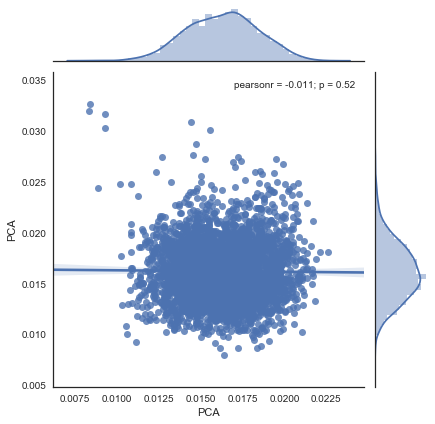

In [20]:
sns.jointplot(df_tf.PCA, df_hfe.PCA, kind='reg')

# Organize Gene-set principal components into one dataframe 

In [10]:
def concat(measure):
    df  = pd.DataFrame(index = df_iron.index, 
                        columns = ['iron', 'da', 'glu', 'gaba', 'anmc', 'top_struct', 'struct'])

    x = 1
    df['top_struct'] = df_iron.top_struct
    df['struct']     = df_iron.struct_name
    df['mni']        = list(zip(df_iron.corrected_mni_x,df_iron.corrected_mni_x,df_iron.corrected_mni_x))
    df['iron']       = df_iron[measure] * x
    df['iron_d']     = df_iron_down[measure] * x
    df['da']         = df_da[measure] * x
    df['da_go']      = df_da_go[measure] * x
    df['da_rb']      = df_da_rb[measure] * x
    df['da_rs']      = df_da_rs[measure] * x
    df['da_t']       = df_da_t[measure] * x
    df['anmc']       = df_anmc[measure] * x
    #df['glu']        = df_glu.PCA * 1000
    #df['gaba']       = df_gaba.PCA * 1000
    #df['gabaglu']    = df_gaba_glu[measure] * 1000
    return df

df = concat('PCA')
df_med = concat('Median')
df_mu = concat('Mean')

NameError: global name 'df_iron_down' is not defined

In [11]:
df.head()

NameError: name 'df' is not defined

# Lets look at the number of unique top level structures

In [49]:
print 'Number of unique top level structures = ', len(df.top_struct.value_counts())
df.top_struct.value_counts()

Number of unique top level structures =  27


frontal lobe             537
temporal lobe            470
cerebellar cortex        337
parietal lobe            290
myelencephalon           279
occipital lobe           212
hippocampal formation    188
mesencephalon            182
dorsal thalamus          175
striatum                 170
cingulate gyrus          148
pontine tegmentum        141
hypothalamus             102
amygdala                  67
parahippocampal gyrus     58
basal forebrain           51
basal part of pons        48
claustrum                 47
insula                    44
globus pallidus           39
ventral thalamus          34
cerebellar nuclei         31
white matter              15
epithalamus               15
subthalamus               14
sulci & spaces             5
brain                      3
Name: top_struct, dtype: int64

In [50]:
print 'Number of unique top level structures = ', len(df.struct.value_counts())
df.struct.value_counts()


Number of unique top level structures =  414


putamen, left                                                          48
superior frontal gyrus, left, medial bank of gyrus                     43
middle temporal gyrus, left, inferior bank of gyrus                    41
superior frontal gyrus, left, lateral bank of gyrus                    40
middle temporal gyrus, left, superior bank of gyrus                    36
pontine nuclei, left                                                   35
spinal trigeminal nucleus, left                                        35
cingulate gyrus, frontal part, left, inferior bank of gyrus            35
claustrum, left                                                        33
inferior temporal gyrus, left, bank of the its                         33
middle frontal gyrus, left, superior bank of gyrus                     33
cingulate gyrus, frontal part, left, superior bank of gyrus            31
inferior temporal gyrus, left, bank of mts                             30
middle frontal gyrus, left, inferior b

In [51]:
all_structures = set(df.top_struct.values)

def extract_struct_expression(df, roi, all_structs):
    drop_structs = [i for i in all_structures if roi not in i]
    df_roi = df[~df['top_struct'].isin(drop_structs)]
    
    return df_roi
print 'Number of unique top level structures = ', len(df.top_struct.value_counts())
df.top_struct.value_counts()
 
df_frontal   = extract_struct_expression(df, 'frontal lobe', all_structures)
df_temporal  = extract_struct_expression(df, 'temporal lobe', all_structures)
df_parietal  = extract_struct_expression(df, 'parietal lobe', all_structures)
df_occipital = extract_struct_expression(df, 'occipital lobe', all_structures)
df_striatum  = extract_struct_expression(df, 'striatum', all_structures)

Number of unique top level structures =  27


# Gene-set fixed effect correlations

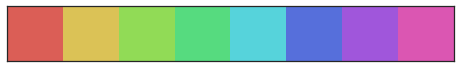

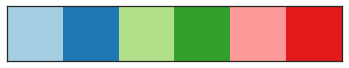

In [52]:
sns.palplot(sns.color_palette("hls", 8))
sns.palplot(sns.color_palette("Paired"))

blue = sns.color_palette("Paired")[1]
green = sns.color_palette("Paired")[3]
red = sns.color_palette("Paired")[5]

In [75]:
def plot(df, met1,met2, cmap, fname):
    grid = sns.JointGrid(met1, met2, data=df) 
    grid.plot_marginals(sns.distplot, color = cmap,hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    grid.plot_joint(sns.regplot, fit_reg=1, scatter= 1, color = cmap, 
                    line_kws={'linestyle': '-', 'lw':2.5}, scatter_kws={"s": 25})

    formula = [ '%s ~ %s'%(met1
                           ,met2)][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = result.pvalues[1]
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    
    xy = (0.015,0.019)
    #xy = (5,5)
    plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = xy, fontsize = 13,  color='r')
    grid.set_axis_labels()
    
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    
    if fname:
        plt.savefig(os.path.join(save_fig_dir, fname), dpi = 500, bbox_inches='tight', transparent = 1, )
    return result

# Whole Brain 

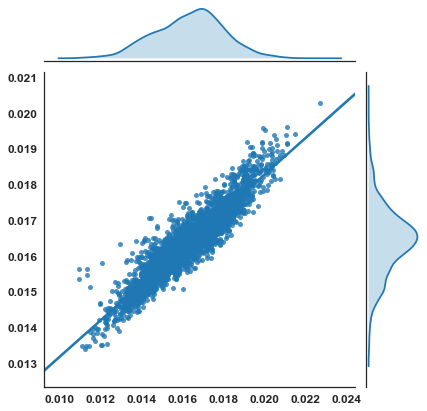

In [54]:
plot(df, 'iron_d','iron', cmap = blue, fname = 'AHBA_full_iron_vs_iron_d')


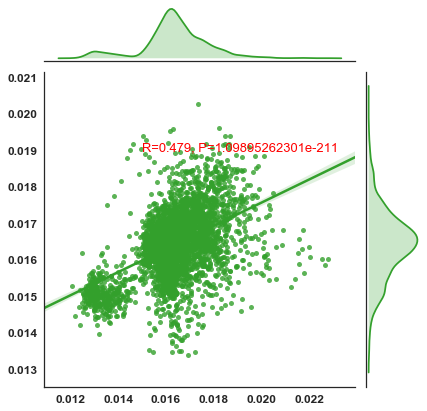

In [80]:
plot(df, 'da','iron', cmap = green, fname = 'AHBA_full_iron_vs_da')


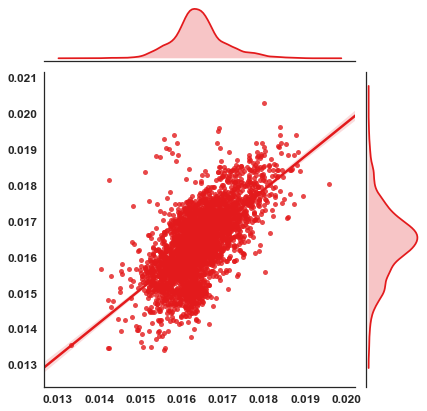

In [56]:
plot(df, 'anmc','iron', cmap = red, fname = 'AHBA_full_iron_vs_amnc')

# Subcortical 


In [78]:
all_structures_small = set(df.struct.values)

def extract_struct_expression(df, roi, all_structures_small):
    drop_structs = [i for i in all_structures_small if roi not in i]
    df_roi = df[~df['struct'].isin(drop_structs)]
    return df_roi

df_sn   = extract_struct_expression(df, 'substantia', all_structures_small)
df_rn   = extract_struct_expression(df, 'red', all_structures_small)
df_stn  = extract_struct_expression(df, 'subthalamic', all_structures_small)
df_caud = extract_struct_expression(df, 'caudate', all_structures_small)
df_pall = extract_struct_expression(df, 'pallidus', all_structures_small)
df_puta = extract_struct_expression(df, 'putamen', all_structures_small)
df_subcortical = pd.concat([df_sn,df_rn,df_stn,df_caud,df_pall,df_puta] )
df_subcortical.to_csv(os.path.join(ahba_dir,'AHBA_subcortical.csv'))

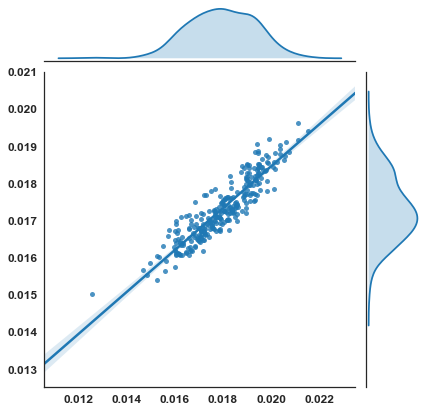

In [58]:
plot(df_subcortical, 'iron_d','iron', cmap = blue, fname = 'AHBA_sub_iron_vs_irond')


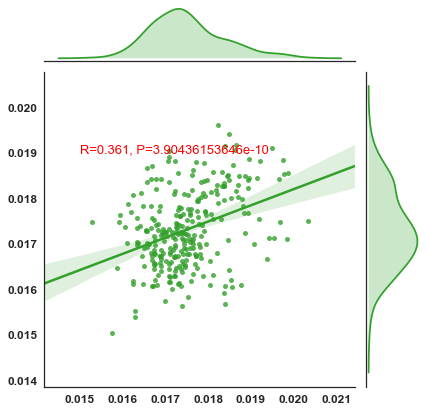

In [85]:
plot(df_subcortical, 'da','iron', cmap = green, fname = 'AHBA_sub_iron_vs_da')


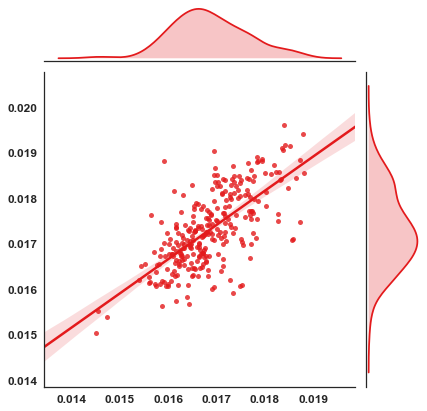

In [60]:
plot(df_subcortical, 'anmc', 'iron', cmap = red, fname = 'AHBA_sub_iron_vs_anmc')

# Striatum 

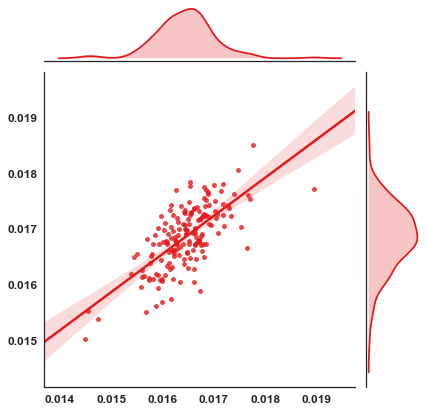

In [61]:
plot(df_striatum, 'anmc', 'iron', cmap = red, fname = 'AHBA_str_iron_vs_anmc')

In [62]:
# PCA explained variance 

def calc_pca_var(df):
    drop = ['coords_native', 'donor_names', 'struct_id', 'struct_name', 'top_struct', 'Mean', 
            'Median', 'PCA', 'corrected_mni_x', 'corrected_mni_y', 'corrected_mni_z']
    df = df.drop(drop, axis = 1)

    from sklearn.decomposition import TruncatedSVD
    pca = TruncatedSVD(n_components=3)
    pca.fit(np.array(np.asarray([df[probe] for probe in df.columns])))
    df['PCA'] = pca.components_[0,:]
    print 'PC1 explained variance:',pca.explained_variance_ratio_

In [63]:
calc_pca_var(df_iron)

PC1 explained variance: [ 0.9729084   0.00582291  0.0040612 ]


In [64]:
calc_pca_var(df_iron_down)

PC1 explained variance: [ 0.86992609  0.06317172  0.02163289]


In [65]:
calc_pca_var(df_da)

PC1 explained variance: [ 0.88968318  0.04680613  0.01624355]


In [66]:
calc_pca_var(df_anmc)

PC1 explained variance: [ 0.92675477  0.0165978   0.00782655]
